In [1]:
!pip install transformers
!pip install torch
!pip install scikit-learn
!pip install pandas
!pip install imbalanced-learn

In [20]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import pandas as pd
import nltk

In [22]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/abi94/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /Users/abi94/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/abi94/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Dataset loading
df = pd.read_csv('data/FinalAnnotationSheet.csv')
texts = df['Body'].tolist()
labels = df['stance comment'].tolist()

In [24]:
def preprocess_text(text):
    '''This function preprocesses the text to prepare it for text mining tasks.
    The text is first lowercased and tokenized, then stopwords are removed, and the text is lemmatized.
    '''
    #tokenize and lowercase the text + define the stopwords and instantiate lemmatizer
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
   
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    #create a single string from the tokens
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

In [28]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

df["cleaned_body"] = df["Body"].apply(preprocess_text)
text_data = df['cleaned_body'].tolist()

#setting up vectorizer with parameter tuning
vectorizer = TfidfVectorizer(
    max_df=0.95,  #setting max document frequency
    min_df=2,  #setting min document frequency
    max_features=5000, 
    ngram_range=(1, 2),
)

X = vectorizer.fit_transform(text_data)

y = df["stance comment"]

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

AttributeError: 'NoneType' object has no attribute 'split'

In [48]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler

# Load the dataset
df = pd.read_excel('data/finalannotation.xlsx')

# Preprocess the text (already cleaned in 'cleaned_body')
texts = df['Body'].tolist()
labels = df["stance comment"].tolist()

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenize and encode the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_inputs = tokenizer(
    texts, 
    max_length=128,  # Truncate or pad to this length
    padding=True, 
    truncation=True,
    return_tensors='pt'
)

# Apply RandomOverSampler to balance the dataset
X_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(
    np.arange(len(labels)).reshape(-1, 1), encoded_labels
)
X_resampled = X_resampled.flatten()

# Split the data
X_train_indices, X_test_indices, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.25, random_state=42
)

# Create PyTorch Datasets using the resampled indices
train_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_train_indices], 
    encoded_inputs['attention_mask'][X_train_indices], 
    torch.tensor(y_train)
)
test_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_test_indices], 
    encoded_inputs['attention_mask'][X_test_indices], 
    torch.tensor(y_test)
)

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset, 
    sampler=RandomSampler(train_dataset), 
    batch_size=16
)
test_dataloader = DataLoader(
    test_dataset, 
    sampler=SequentialSampler(test_dataset), 
    batch_size=16
)

# Define the model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_encoder.classes_)
)

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 3  # Number of training epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(1):  # Number of epochs
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")

# Evaluation
model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    with torch.no_grad():
        input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 1.2027581291539329
Test Accuracy: 76.92%


In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

Confusion Matrix:
[[ 62   9  16  34]
 [  6 120   1   7]
 [  2   0 126   0]
 [ 29  10   6  92]]


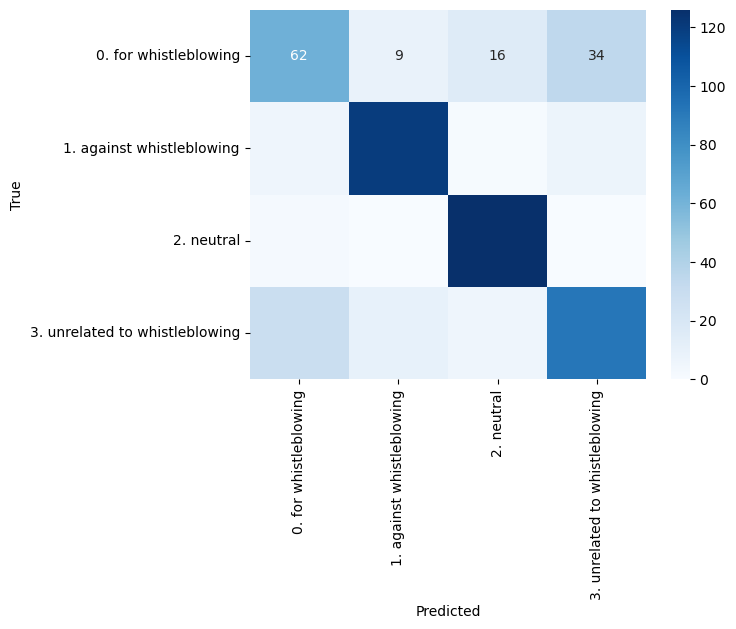

In [60]:
# Calculate and print the confusion matrix
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [62]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.63      0.51      0.56       121
           1       0.86      0.90      0.88       134
           2       0.85      0.98      0.91       128
           3       0.69      0.67      0.68       137

    accuracy                           0.77       520
   macro avg       0.76      0.77      0.76       520
weighted avg       0.76      0.77      0.76       520



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training Loss: 1.2432220562910423
Epoch 1, Validation Loss: 1.0357078061654017, Validation Accuracy: 53.61%
Test Accuracy: 51.92%
Confusion Matrix:
[[ 14  66   5  15]
 [  3 105   0   3]
 [  0   5  80   3]
 [  6  91   3  17]]


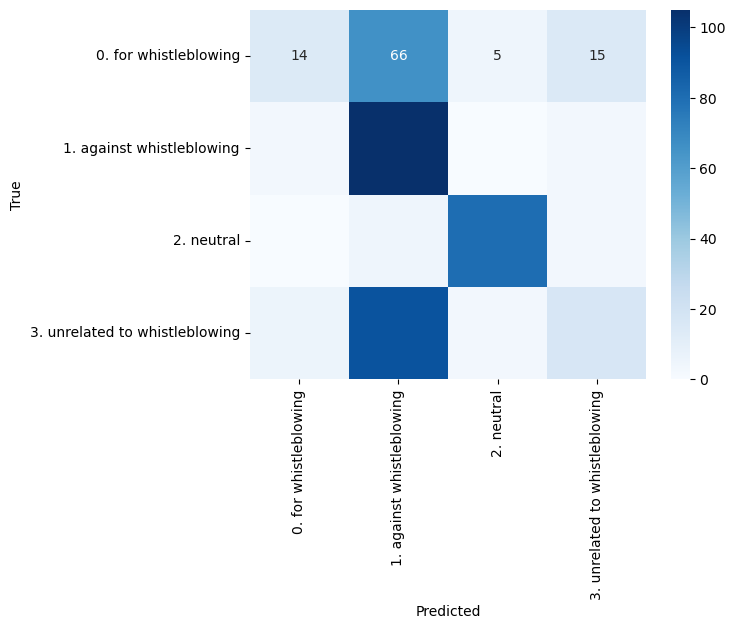

In [64]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel('data/finalannotation.xlsx')

# Preprocess the text (already cleaned in 'cleaned_body')
texts = df['Body'].tolist()
labels = df["stance comment"].tolist()

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenize and encode the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_inputs = tokenizer(
    texts, 
    max_length=128,  # Truncate or pad to this length
    padding=True, 
    truncation=True,
    return_tensors='pt'
)

# Apply RandomOverSampler to balance the dataset
X_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(
    np.arange(len(labels)).reshape(-1, 1), encoded_labels
)
X_resampled = X_resampled.flatten()

# Split the data into training, validation, and test sets
X_train_indices, X_temp_indices, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=0.4, random_state=42
)
X_val_indices, X_test_indices, y_val, y_test = train_test_split(
    X_temp_indices, y_temp, test_size=0.5, random_state=42
)

# Create PyTorch Datasets using the resampled indices
train_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_train_indices], 
    encoded_inputs['attention_mask'][X_train_indices], 
    torch.tensor(y_train)
)
val_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_val_indices], 
    encoded_inputs['attention_mask'][X_val_indices], 
    torch.tensor(y_val)
)
test_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_test_indices], 
    encoded_inputs['attention_mask'][X_test_indices], 
    torch.tensor(y_test)
)

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset, 
    sampler=RandomSampler(train_dataset), 
    batch_size=16
)
val_dataloader = DataLoader(
    val_dataset, 
    sampler=SequentialSampler(val_dataset), 
    batch_size=16
)
test_dataloader = DataLoader(
    test_dataset, 
    sampler=SequentialSampler(test_dataset), 
    batch_size=16
)

# Define the model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_encoder.classes_)
)

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 3  # Number of training epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(1):  # Number of epochs
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}")

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []
    for batch in val_dataloader:
        with torch.no_grad():
            input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
            outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = accuracy_score(true_labels, predictions)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluation on test data
model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    with torch.no_grad():
        input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(true_labels, predictions)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Calculate and print the confusion matrix
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 1.2089318946385994
Validation Accuracy: 53.85%
Validation F1 Score: 0.45
Epoch 2, Loss: 0.8871494990128738
Validation Accuracy: 64.42%
Validation F1 Score: 0.62
Epoch 3, Loss: 0.7915394134246386
Validation Accuracy: 67.55%
Validation F1 Score: 0.65
Test Accuracy: 63.94%
Confusion Matrix:
[[56 36  3  5]
 [17 89  0  5]
 [ 0  0 88  0]
 [40 43  1 33]]


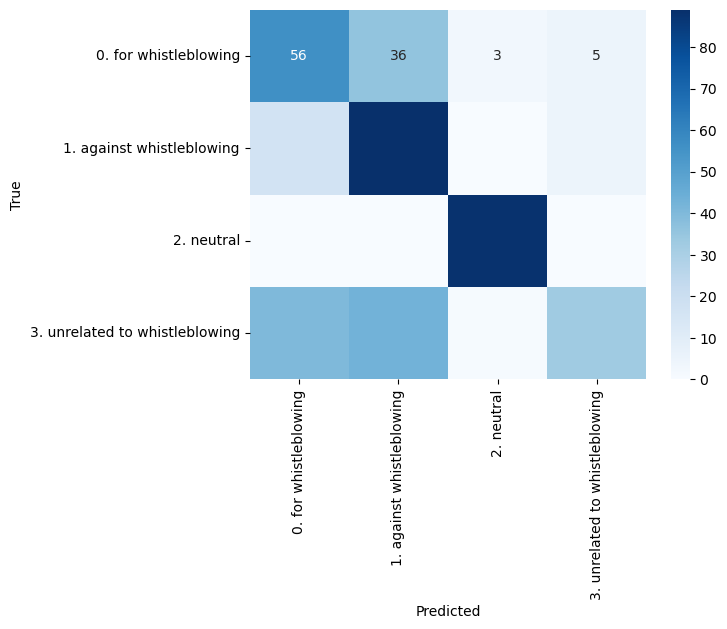

Standard Deviation of Validation Accuracy: 0.06
Standard Deviation of Validation F1 Score: 0.09


In [66]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel('data/finalannotation.xlsx')

# Preprocess the text (already cleaned in 'cleaned_body')
texts = df['Body'].tolist()
labels = df["stance comment"].tolist()

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenize and encode the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_inputs = tokenizer(
    texts, 
    max_length=128,  # Truncate or pad to this length
    padding=True, 
    truncation=True,
    return_tensors='pt'
)

# Apply RandomOverSampler to balance the dataset
X_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(
    np.arange(len(labels)).reshape(-1, 1), encoded_labels
)
X_resampled = X_resampled.flatten()

# Split the data into train, validation, and test sets
X_train_indices, X_temp_indices, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=0.4, random_state=42
)
X_val_indices, X_test_indices, y_val, y_test = train_test_split(
    X_temp_indices, y_temp, test_size=0.5, random_state=42
)

# Create PyTorch Datasets using the resampled indices
train_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_train_indices], 
    encoded_inputs['attention_mask'][X_train_indices], 
    torch.tensor(y_train)
)
val_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_val_indices], 
    encoded_inputs['attention_mask'][X_val_indices], 
    torch.tensor(y_val)
)
test_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_test_indices], 
    encoded_inputs['attention_mask'][X_test_indices], 
    torch.tensor(y_test)
)

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset, 
    sampler=RandomSampler(train_dataset), 
    batch_size=16
)
val_dataloader = DataLoader(
    val_dataset, 
    sampler=SequentialSampler(val_dataset), 
    batch_size=16
)
test_dataloader = DataLoader(
    test_dataset, 
    sampler=SequentialSampler(test_dataset), 
    batch_size=16
)

# Define the model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_encoder.classes_)
)

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 3  # Number of training epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

validation_accuracies = []
validation_f1_scores = []

for epoch in range(3):  # Number of epochs
    # Training phase
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")

    # Validation phase
    model.eval()
    val_predictions, val_true_labels = [], []
    for batch in val_dataloader:
        with torch.no_grad():
            input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits
            val_predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())
    
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    val_f1 = f1_score(val_true_labels, val_predictions, average='weighted')
    validation_accuracies.append(val_accuracy)
    validation_f1_scores.append(val_f1)
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Validation F1 Score: {val_f1:.2f}")

# Evaluation on test set
model.eval()
test_predictions, test_true_labels = [], []
for batch in test_dataloader:
    with torch.no_grad():
        input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        test_predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(test_true_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Calculate and print the confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calculate standard deviation of accuracy and F1 score for validation
std_accuracy = np.std(validation_accuracies)
std_f1 = np.std(validation_f1_scores)
print(f'Standard Deviation of Validation Accuracy: {std_accuracy:.2f}')
print(f'Standard Deviation of Validation F1 Score: {std_f1:.2f}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 1.049688182972573
Validation Accuracy: 58.88%
Validation F1 Score: 0.58
Epoch 2, Loss: 0.8345179445034748
Validation Accuracy: 74.11%
Validation F1 Score: 0.73
Epoch 3, Loss: 0.6409143354441669
Validation Accuracy: 75.13%
Validation F1 Score: 0.75
Test Accuracy: 75.25%
Confusion Matrix:
[[47 18  8]
 [15 40  7]
 [ 0  1 62]]


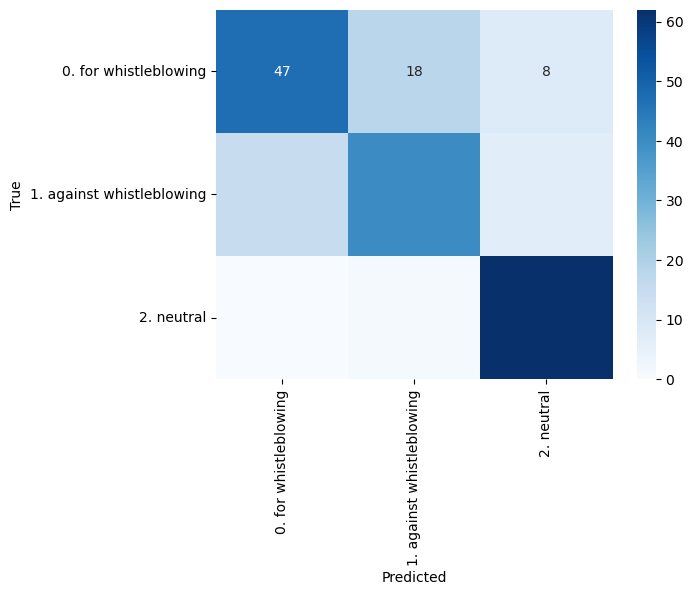

Standard Deviation of Validation Accuracy: 0.07
Standard Deviation of Validation F1 Score: 0.07


In [15]:
#RemovedneutralUnrelated
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel('data/File_NoUnrelated_StanceComment.xlsx')

# Preprocess the text (already cleaned in 'cleaned_body')
texts = df['Body'].tolist()
labels = df["stance comment"].tolist()

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenize and encode the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_inputs = tokenizer(
    texts, 
    max_length=128,  # Truncate or pad to this length
    padding=True, 
    truncation=True,
    return_tensors='pt'
)

# Apply RandomOverSampler to balance the dataset
X_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(
    np.arange(len(labels)).reshape(-1, 1), encoded_labels
)
X_resampled = X_resampled.flatten()

# Split the data into train, validation, and test sets
X_train_indices, X_temp_indices, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=0.4, random_state=42
)
X_val_indices, X_test_indices, y_val, y_test = train_test_split(
    X_temp_indices, y_temp, test_size=0.5, random_state=42
)

# Create PyTorch Datasets using the resampled indices
train_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_train_indices], 
    encoded_inputs['attention_mask'][X_train_indices], 
    torch.tensor(y_train)
)
val_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_val_indices], 
    encoded_inputs['attention_mask'][X_val_indices], 
    torch.tensor(y_val)
)
test_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_test_indices], 
    encoded_inputs['attention_mask'][X_test_indices], 
    torch.tensor(y_test)
)

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset, 
    sampler=RandomSampler(train_dataset), 
    batch_size=16
)
val_dataloader = DataLoader(
    val_dataset, 
    sampler=SequentialSampler(val_dataset), 
    batch_size=16
)
test_dataloader = DataLoader(
    test_dataset, 
    sampler=SequentialSampler(test_dataset), 
    batch_size=16
)

# Define the model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_encoder.classes_)
)

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 3  # Number of training epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

validation_accuracies = []
validation_f1_scores = []

for epoch in range(3):  # Number of epochs
    # Training phase
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")

    # Validation phase
    model.eval()
    val_predictions, val_true_labels = [], []
    for batch in val_dataloader:
        with torch.no_grad():
            input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits
            val_predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())
    
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    val_f1 = f1_score(val_true_labels, val_predictions, average='weighted')
    validation_accuracies.append(val_accuracy)
    validation_f1_scores.append(val_f1)
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Validation F1 Score: {val_f1:.2f}")

# Evaluation on test set
model.eval()
test_predictions, test_true_labels = [], []
for batch in test_dataloader:
    with torch.no_grad():
        input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        test_predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(test_true_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Calculate and print the confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calculate standard deviation of accuracy and F1 score for validation
std_accuracy = np.std(validation_accuracies)
std_f1 = np.std(validation_f1_scores)
print(f'Standard Deviation of Validation Accuracy: {std_accuracy:.2f}')
print(f'Standard Deviation of Validation F1 Score: {std_f1:.2f}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.7018705034255981
Validation Accuracy: 54.55%
Validation F1 Score: 0.55
Epoch 2, Loss: 0.6538707733154296
Validation Accuracy: 52.27%
Validation F1 Score: 0.52
Epoch 3, Loss: 0.6223423218727112
Validation Accuracy: 57.58%
Validation F1 Score: 0.57
Test Accuracy: 62.12%
Confusion Matrix:
[[33 31]
 [19 49]]


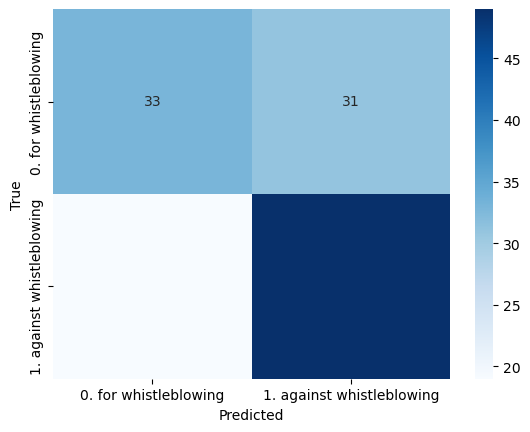

Standard Deviation of Validation Accuracy: 0.02
Standard Deviation of Validation F1 Score: 0.02


In [19]:
#SMOTENeutralUnrealtedRemoved
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel('data/RemoveNeutralUnrealted.xlsx')

# Preprocess the text (already cleaned in 'cleaned_body')
texts = df['Body'].tolist()
labels = df["stance comment"].tolist()

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenize and encode the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_inputs = tokenizer(
    texts, 
    max_length=128,  # Truncate or pad to this length
    padding=True, 
    truncation=True,
    return_tensors='pt'
)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(
    np.arange(len(labels)).reshape(-1, 1), encoded_labels
)
X_resampled = X_resampled.flatten()

# Split the data into train, validation, and test sets
X_train_indices, X_temp_indices, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=0.4, random_state=42
)
X_val_indices, X_test_indices, y_val, y_test = train_test_split(
    X_temp_indices, y_temp, test_size=0.5, random_state=42
)

# Create PyTorch Datasets using the resampled indices
train_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_train_indices], 
    encoded_inputs['attention_mask'][X_train_indices], 
    torch.tensor(y_train)
)
val_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_val_indices], 
    encoded_inputs['attention_mask'][X_val_indices], 
    torch.tensor(y_val)
)
test_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_test_indices], 
    encoded_inputs['attention_mask'][X_test_indices], 
    torch.tensor(y_test)
)

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset, 
    sampler=RandomSampler(train_dataset), 
    batch_size=16
)
val_dataloader = DataLoader(
    val_dataset, 
    sampler=SequentialSampler(val_dataset), 
    batch_size=16
)
test_dataloader = DataLoader(
    test_dataset, 
    sampler=SequentialSampler(test_dataset), 
    batch_size=16
)

# Define the model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_encoder.classes_)
)

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 3  # Number of training epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

validation_accuracies = []
validation_f1_scores = []

for epoch in range(3):  # Number of epochs
    # Training phase
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")

    # Validation phase
    model.eval()
    val_predictions, val_true_labels = [], []
    for batch in val_dataloader:
        with torch.no_grad():
            input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits
            val_predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())
    
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    val_f1 = f1_score(val_true_labels, val_predictions, average='weighted')
    validation_accuracies.append(val_accuracy)
    validation_f1_scores.append(val_f1)
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Validation F1 Score: {val_f1:.2f}")

# Evaluation on test set
model.eval()
test_predictions, test_true_labels = [], []
for batch in test_dataloader:
    with torch.no_grad():
        input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        test_predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(test_true_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Calculate and print the confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calculate standard deviation of accuracy and F1 score for validation
std_accuracy = np.std(validation_accuracies)
std_f1 = np.std(validation_f1_scores)
print(f'Standard Deviation of Validation Accuracy: {std_accuracy:.2f}')
print(f'Standard Deviation of Validation F1 Score: {std_f1:.2f}')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.5842383766875547
Validation Accuracy: 75.00%
Validation F1 Score: 0.64
Epoch 2, Loss: 0.5549392559949089
Validation Accuracy: 75.00%
Validation F1 Score: 0.64
Epoch 3, Loss: 0.49700135080253377
Validation Accuracy: 75.00%
Validation F1 Score: 0.64
Test Accuracy: 77.27%
Confusion Matrix:
[[68  1]
 [19  0]]


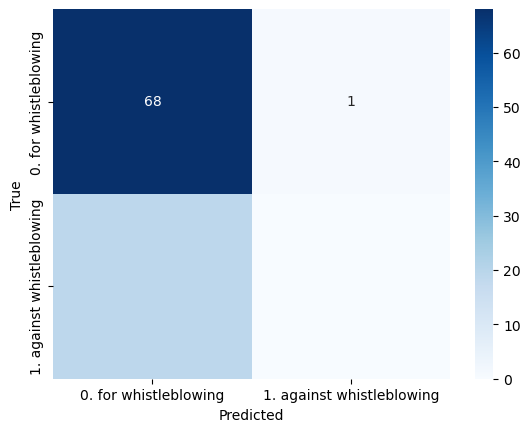

Standard Deviation of Validation Accuracy: 0.00
Standard Deviation of Validation F1 Score: 0.00


In [23]:
#NoSamplingNeutralUnrealtedRemoved
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel('data/RemoveNeutralUnrealted.xlsx')

# Preprocess the text (already cleaned in 'cleaned_body')
texts = df['Body'].tolist()
labels = df["stance comment"].tolist()

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenize and encode the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_inputs = tokenizer(
    texts, 
    max_length=128,  # Truncate or pad to this length
    padding=True, 
    truncation=True,
    return_tensors='pt'
)

# Split the data into train, validation, and test sets
X_train_indices, X_temp_indices, y_train, y_temp = train_test_split(
    np.arange(len(labels)), encoded_labels, test_size=0.4, random_state=42
)
X_val_indices, X_test_indices, y_val, y_test = train_test_split(
    X_temp_indices, y_temp, test_size=0.5, random_state=42
)

# Create PyTorch Datasets using the resampled indices
train_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_train_indices], 
    encoded_inputs['attention_mask'][X_train_indices], 
    torch.tensor(y_train)
)
val_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_val_indices], 
    encoded_inputs['attention_mask'][X_val_indices], 
    torch.tensor(y_val)
)
test_dataset = TensorDataset(
    encoded_inputs['input_ids'][X_test_indices], 
    encoded_inputs['attention_mask'][X_test_indices], 
    torch.tensor(y_test)
)

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset, 
    sampler=RandomSampler(train_dataset), 
    batch_size=16
)
val_dataloader = DataLoader(
    val_dataset, 
    sampler=SequentialSampler(val_dataset), 
    batch_size=16
)
test_dataloader = DataLoader(
    test_dataset, 
    sampler=SequentialSampler(test_dataset), 
    batch_size=16
)

# Define the model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_encoder.classes_)
)

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 3  # Number of training epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

validation_accuracies = []
validation_f1_scores = []

for epoch in range(3):  # Number of epochs
    # Training phase
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")

    # Validation phase
    model.eval()
    val_predictions, val_true_labels = [], []
    for batch in val_dataloader:
        with torch.no_grad():
            input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits
            val_predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())
    
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    val_f1 = f1_score(val_true_labels, val_predictions, average='weighted')
    validation_accuracies.append(val_accuracy)
    validation_f1_scores.append(val_f1)
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Validation F1 Score: {val_f1:.2f}")

# Evaluation on test set
model.eval()
test_predictions, test_true_labels = [], []
for batch in test_dataloader:
    with torch.no_grad():
        input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        test_predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(test_true_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Calculate and print the confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calculate standard deviation of accuracy and F1 score for validation
std_accuracy = np.std(validation_accuracies)
std_f1 = np.std(validation_f1_scores)
print(f'Standard Deviation of Validation Accuracy: {std_accuracy:.2f}')
print(f'Standard Deviation of Validation F1 Score: {std_f1:.2f}')
